# pytorch进阶训练技巧

## 自定义损失函数

### 函数方式定义

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [2]:
def my_loss(output, target):
    loss = torch.mean((output - target) ** 2)
    return loss

### 类的方式定义

In [7]:
# 类方式定义，损失函数需要继承自nn.Module类
# Dice Loss DSC = 2|x ∩ y| / (|x| + |y|)
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
    
    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return dice

criterion = DiceLoss()
input = torch.ones(3, 3)
target = torch.ones(3, 3)
criterion.forward(input, target)

D:\Users\15620\anaconda3\envs\paiflow\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.8540)

In [9]:
# FocalLoss
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()
    
    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1 - BCE_EXP)**gamma * BCE
        
        return focal_loss

FLoss = FocalLoss()
FLoss.forward(input, target)

tensor(0.0181)

### 涉及数学运算时，最好使用pytorch提供的tensor计算接口，这样不需要我们实现自动求导功能，并且可以直接调用cuda；numpy,scipy用来实现计算后续处理会比较麻烦

## 动态调整学习率

In [17]:
# Assuming optimizer uses lr = 0.05 for all groups
# lr = 0.05     if epoch < 30
# lr = 0.005    if 30 <= epoch < 80
# lr = 0.0005   if epoch >= 80
optimizer = torch.optim.Adam({torch.ones(2,2)})
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1) #gamma为满足条件(迭代次数达到30和80后)后，学习率=学习率*gamma
for epoch in range(100):
    train(...) #训练模型
    validate(...) #计算损失，反向传播，优化参数--梯度下降 等等
    scheduler.step() #如果满足函数太偶见，动态调整学习率
    ## 注意动态学习率调整函数要放在优化函数后面

NameError: name 'train' is not defined

In [ ]:
# 自定义学习率调整策略
def adjust_learning_rate(optimizer, epoch):
    lr = args.lr * (0.1 ** (epoch // 30)) # 学习率 乘 0.1的（迭代次数//30）的次方
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## 模型微调

**迁移学习：将从源数据集学到的知识迁移到目标数据集上；<br>
模型微调：找一个别人训练好的模型，把自己的数据输入进去，通过训练调整一下参数**

### 模型微调流程

In [6]:
# 实例化网络
inception = models.inception_v3(pretrained=True) #pretained为True表示使用训练好的权重；否则只使用网络架构
# 训练特定层
def set_parameter_requires_grad(model, feature_extracting): # 冻结模型参数
    if feature_extracting: # 条件成立
        for param in model.parameters():
            param.requires_grad = False # 不计算梯度，参数不会改变

feature_extract = True
model = models.inception_v3(pretrained=True) # 使用预训练好的模型
set_parameter_requires_grad(model, feature_extract) # 对模型进行冻结

num_ftrs = model.fc.in_features # 全连接层输入特征数,方便后续匹配--(fc): Linear(in_features=2048, out_features=1000, bias=True)
model.fc = nn.Linear(in_features=num_ftrs, out_features=4, bias=True) #修改输出结果数为4个

D:\Users\15620\anaconda3\envs\paiflow\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
D:\Users\15620\anaconda3\envs\paiflow\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\15620/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
22.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

**上述实例，我们对模型进行微调，实际应用中我们要根据具体情况进行选择。<br>
数据集大相似度高，保留模型权重并进行整体训练.<br>
数据集大，相似度低，根据自己的数据重新训练网络.<br>
数据集小，相似度高。只需修改最后几层，输出<br>
数据集小，相似度低。可以后选择冻结前多少层，训练之后层**

## 使用timm模型库, 包含很多计算机视觉的SOTA模型

In [7]:
import timm
avail_pretained_models = timm.list_models(pretrained=True)
len(avail_pretained_models)

765

In [8]:
total_models = timm.list_models()
total_models

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw

In [9]:
avail_pretained_models

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1

In [11]:
all_densenet_models = timm.list_models("*densenet*")
all_densenet_models

['densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'tv_densenet121']

In [13]:
model = timm.create_model('resnet34', num_classes=10, pretrained=True)
model.default_cfg

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to C:\Users\15620/.cache\torch\hub\checkpoints\resnet34-43635321.pth


{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bilinear',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnet34'}

### 使用和修改预训练模型

In [14]:
model = timm.create_model('resnet34', pretrained=True) # 创建模型
x = torch.randn(1, 3, 224, 224)
output = model(x)
output.shape

torch.Size([1, 1000])

In [15]:
# 查看某一层模型参数
list(dict(model.named_children())['conv1'].parameters())

[Parameter containing:
 tensor([[[[-2.9398e-02, -3.6421e-02, -2.8832e-02,  ..., -1.8349e-02,
            -6.9210e-03,  1.2127e-02],
           [-3.6199e-02, -6.0810e-02, -5.3891e-02,  ..., -4.2744e-02,
            -7.3169e-03, -1.1834e-02],
           [-5.5227e-02, -7.2939e-02, -7.2351e-02,  ..., -7.1478e-02,
            -3.4954e-02, -4.0736e-02],
           ...,
           [-2.3535e-02, -5.1401e-02, -6.0092e-02,  ..., -7.2196e-02,
            -4.7019e-02, -2.5696e-02],
           [ 7.5010e-04, -1.6182e-02, -2.8829e-02,  ..., -3.6269e-02,
             1.1061e-02,  1.2223e-02],
           [ 8.1931e-03, -2.2972e-02, -1.6335e-02,  ..., -3.1251e-02,
             1.0593e-02, -6.2252e-03]],
 
          [[ 1.5982e-02,  3.5244e-03,  3.9051e-03,  ...,  2.4932e-02,
             2.8518e-02,  2.5999e-02],
           [ 5.7787e-03, -1.7177e-02, -1.6884e-02,  ...,  4.3224e-04,
             3.5190e-02,  3.2971e-02],
           [-1.1372e-02, -3.4875e-02, -4.0418e-02,  ..., -3.1364e-02,
            -3.9

In [16]:
# 修改模型，将1000类输出改为10类输出
model = timm.create_model('resnet34', num_classes=10, pretrained=True) #num_classes是模型定义的其他参数，默认是1000
x = torch.randn(1, 3, 224, 224)
output = model(x)
output.shape

torch.Size([1, 10])

In [17]:
# 将输入通道数由3改为1
model = timm.create_model('resnet34', num_classes=10, pretrained=True, in_chans=1)
x = torch.randn(1, 1, 224, 224)
output = model(x)
output

tensor([[ 0.0793, -0.0673,  0.4658, -0.5201, -0.1157,  0.1121, -0.0897,  0.1466,
          0.0593, -0.4408]], grad_fn=<AddmmBackward0>)

#**修改模型输入尺寸，没有此声明**
model = timm.create_model('resnet34', input_size=(3, 448, 448), pretrained=True)<br>
x = torch.randn(4, 3, 448, 448)<br>
output = model(x)<br>
output.shape

In [28]:
### 模型保存和加载使用，torch自带函数
torch.save(model, './test/resnet34.ph') #保存模型，路径名需要有保存的文件名

In [29]:
model = torch.load('./test/resnet34.ph') # 加载模型

## 半精度训练

In [31]:
torch.float == torch.float32

True

In [32]:
# Pytorch中使用autocast配置半精度训练
from torch.cuda.amp import autocast

# 模型设置
@autocast
def forward(self, x):
    ...
    return x

# 训练过程,只需将数据输入模型及其之后的部分放入“with autocast():”即可
for x in train_loader:
    x = x.cuda()
    with autocast():
        output = model(x)
        ...

NameError: name 'train_loader' is not defined

**半精度训练主要适用于数据本身的sizie比较大；数据本身size不大时，使用半精度训练可能不会带来较大的提升**

## 数据增强-imagaug

In [33]:
# 单张图片处理
import imageio
import imgaug as ia
%matplotlib inline

D:\Users\15620\anaconda3\envs\paiflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.


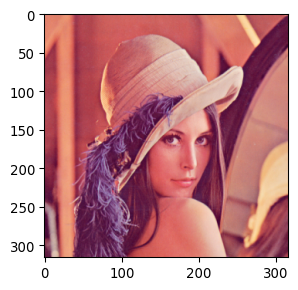

In [35]:
img = imageio.imread('./test/Lenna.jpg')
ia.imshow(img)

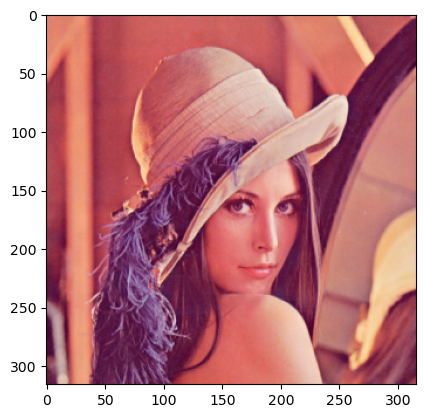

In [36]:
import matplotlib.pyplot as plt
plt.imshow(img)

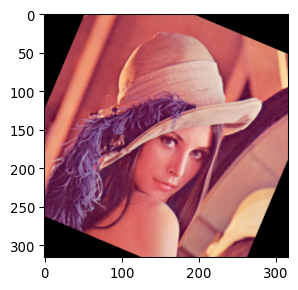

In [37]:
# 数据增强操作
from imgaug import augmenters as iaa

ia.seed(4) #设置随机数种子

#实例化方法
rotate = iaa.Affine(rotate=(-4, 45)) #从-4度角到45度角随机选一个值
img_aug = rotate(image=img)
ia.imshow(img_aug)

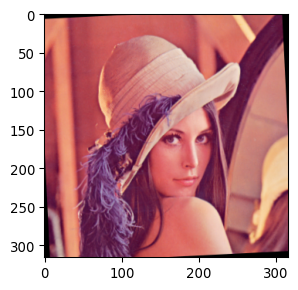

In [40]:
rotate1 = iaa.Affine(rotate=(-4, 45))
img_aug1 = rotate1(image=img)
ia.imshow(img_aug1)

In [41]:
# 对一张图片进行多种数据增强处理，与torchvision.transforms.Compose()相类似
iaa.Sequential(children=None,  #Augmenter集合
              random_order=False, #是否对每个batch使用不同顺序的数据增强
              name=None,
              deterministic=False, #已被移除
              random_state=None)

D:\Users\15620\anaconda3\envs\paiflow\lib\site-packages\imgaug\augmenters\meta.py:3091: DeprecationWarning: The parameter `deterministic` is deprecated in `imgaug.augmenters.meta.Augmenter`. Use `.to_deterministic()` to switch into deterministic mode.
  random_state=random_state, deterministic=deterministic)


Sequential(name=UnnamedSequential, random_order=False, children=[], deterministic=False)

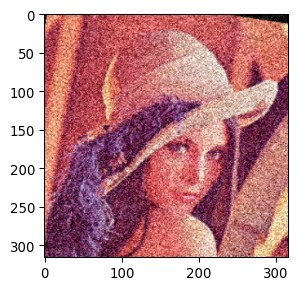

In [52]:
# 构件处理序列
aug_seq = iaa.Sequential([
    iaa.Affine(rotate=(-25,25)),
    iaa.AdditiveGaussianNoise(scale=(10, 60)),
    iaa.Crop(percent=(0.2,0.))
])
image_aug = aug_seq(image=img)
ia.imshow(image_aug)

### 对批次图片进行处理

In [53]:
# demo.py
import argparse

# 创建ArgumentParser()对象
parser = argparse.ArgumentParser()

# 添加参数
parser.add_argument('-o', '--output', action='store_true', 
    help="shows output")
# action = `store_true` 会将output参数记录为True
# type 规定了参数的格式
# default 规定了默认值
parser.add_argument('--lr', type=float, default=3e-5, help='select the learning rate, default=1e-3') 

parser.add_argument('--batch_size', type=int, required=True, help='input batch size')  
# 使用parse_args()解析函数
args = parser.parse_args()

if args.output:
    print("This is some output")
    print(f"learning rate:{args.lr} ")


usage: ipykernel_launcher.py [-h] [-o] [--lr LR] --batch_size BATCH_SIZE
ipykernel_launcher.py: error: the following arguments are required: --batch_size


SystemExit: 2

D:\Users\15620\anaconda3\envs\paiflow\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### imgaug在pytorch中的应用

In [55]:
# 构建pipeline
import torchvision.transforms as transforms
tfs = transforms.Compose([
    iaa.Sequential([
        iaa.flip.Fliplr(p=0.5), #水平/镜像输入图片
        iaa.flip.Flipud(p=0.5), #垂直翻转/镜像翻转图片
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.MultiplyBrightness(mul=(0.65, 1.35))
    ]).augment_image,
    transforms.ToTensor() #转变为张量
])
# 将tfs作为图片增广器使用就可以了

## 使用argparse调参
**argparse为我们提供了一种便捷方式，实现参数的保存和模型输出的记录**


# pytorch模型定义及进阶训练技巧